In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import random

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The **SocBERT** model used is a *Socbert-cased* fine-tuned implementation, with the addition of an output layer made of some neurons, responsibles for the classification task.<br>
What follows is the work pipeline used on **SocBERT** model:
1. Cross Validation
2. Cleaning validation
3. Training the final model: *Socbert*
4. Mapping *Socbert* predictions to the Ekman taxonomy
5. Training with the Ekman-mapped training-set the model *Socbert_Ekman*
6. Testing *Socbert* generalizzation capabilities on the twitter dataset

Due to GPU memory limitations there are repeated chunks of code over the cells, so that they can be executed atomically. <br>

In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'Socbert'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
EPOCHS = 4
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


## 1. Cross Validation
We try to get the best parameters for a Socbert model on the goEmotions dataset

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 2e-05,1e-04],
    'regularization': [0, 1e-05],
    'batch_size': [16],
    'epochs': [EPOCHS],
    'n_classes': [len(LABEL_COLS)],
    'tokenizer_max_len' :[100]
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Socbert, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

0it [00:00, ?it/s]

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])

BEST MODEL INFO
{'batch_size': 16.0, 'epochs': 4.0, 'learning_rate': 5e-05, 'n_classes': 28.0, 'regularization': 0.0, 'tokenizer_max_len': 100.0, 'train_accuracy': 0.5053674268601704, 'train_jaccard_macro': 0.3888154071983982, 'train_f1_macro': 0.5380259845241877, 'train_jaccard_samples': 0.603378637794671, 'train_f1_micro': 0.6418431866957953, 'train_membership': 0.6782077862243723, 'val_accuracy': 0.4758569848875783, 'val_jaccard_macro': 0.3577959712303641, 'val_f1_macro': 0.5059803455689765, 'val_jaccard_samples': 0.5659018306917312, 'val_f1_micro': 0.5990584240179054, 'val_membership': 0.6284555842241062}
RESULTS
    batch_size  epochs  learning_rate  n_classes  regularization  \
0           16       6        0.00005         28         0.00000   
1           16       6        0.00005         28         0.00001   
2           16       6        0.00002         28         0.00000   
3           16       6        0.00002         28         0.00001   
4           16       6        0.000

## 2. Cleaning Validation
The cleaning validation consist of a comparison between two models trained using as the training sets, the standard one and a cleaned (using the notebook *GoEmotions_data_preparation*) version of the latter. In order to make a fair comparison, the seed value responsible for the initializzation of the *socbert* model output layer's weights is fixed for both models, moreover there is no shuffling of the dataset during batch creations.

### Socbert_cleaned
The following is the best set of hyperparameters

In [5]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'SocbertCleaned'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 0
LEARNING_RATE = 5e-05
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()

In [6]:
# model parameters
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS),
          "tokenizer_max_len" :100}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
# creating the 
# we set a seed ti get the sane weight initializzazion for the data prep validation
             

In [7]:
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Socbert(SCORES,
             PARAMS)    
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

In [ ]:
model = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE) 

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


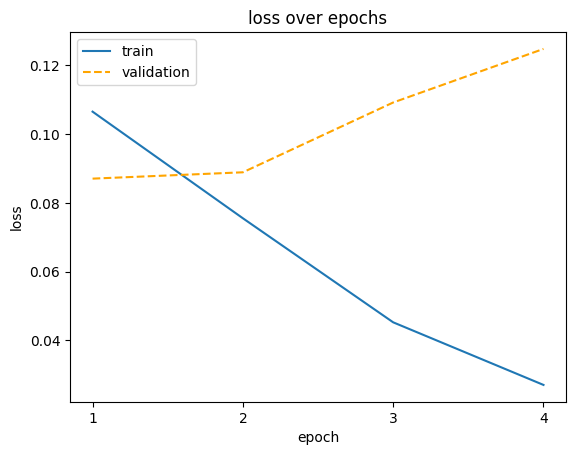

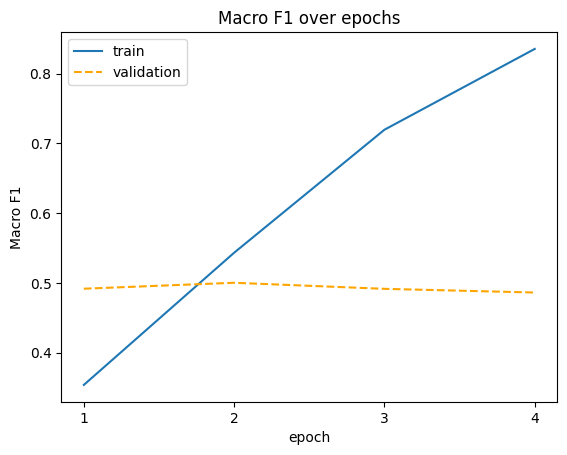

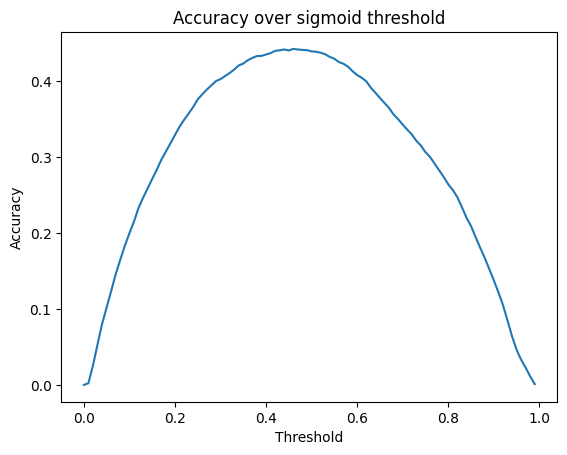

Best threshold: 0.46
Best Accuracy: 0.4428676741614449


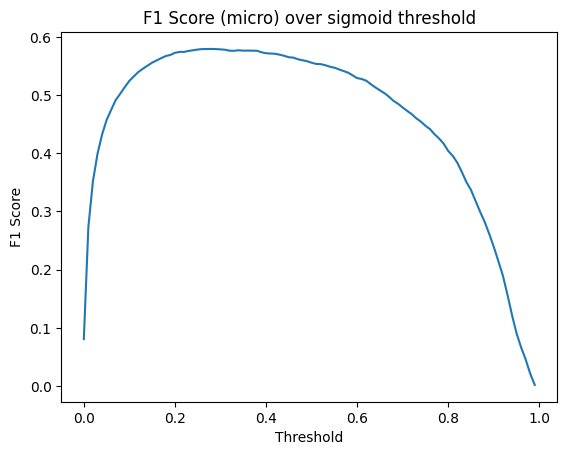

Best threshold: 0.28
Best F1 Score (micro): 0.579252390611417


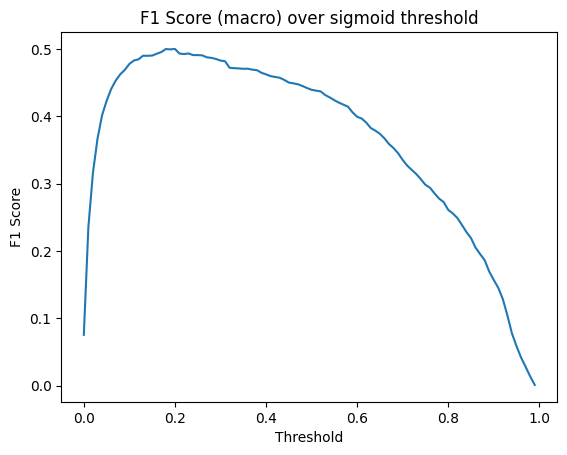

Best threshold: 0.2
Best F1 Score (macro): 0.5001805990007133


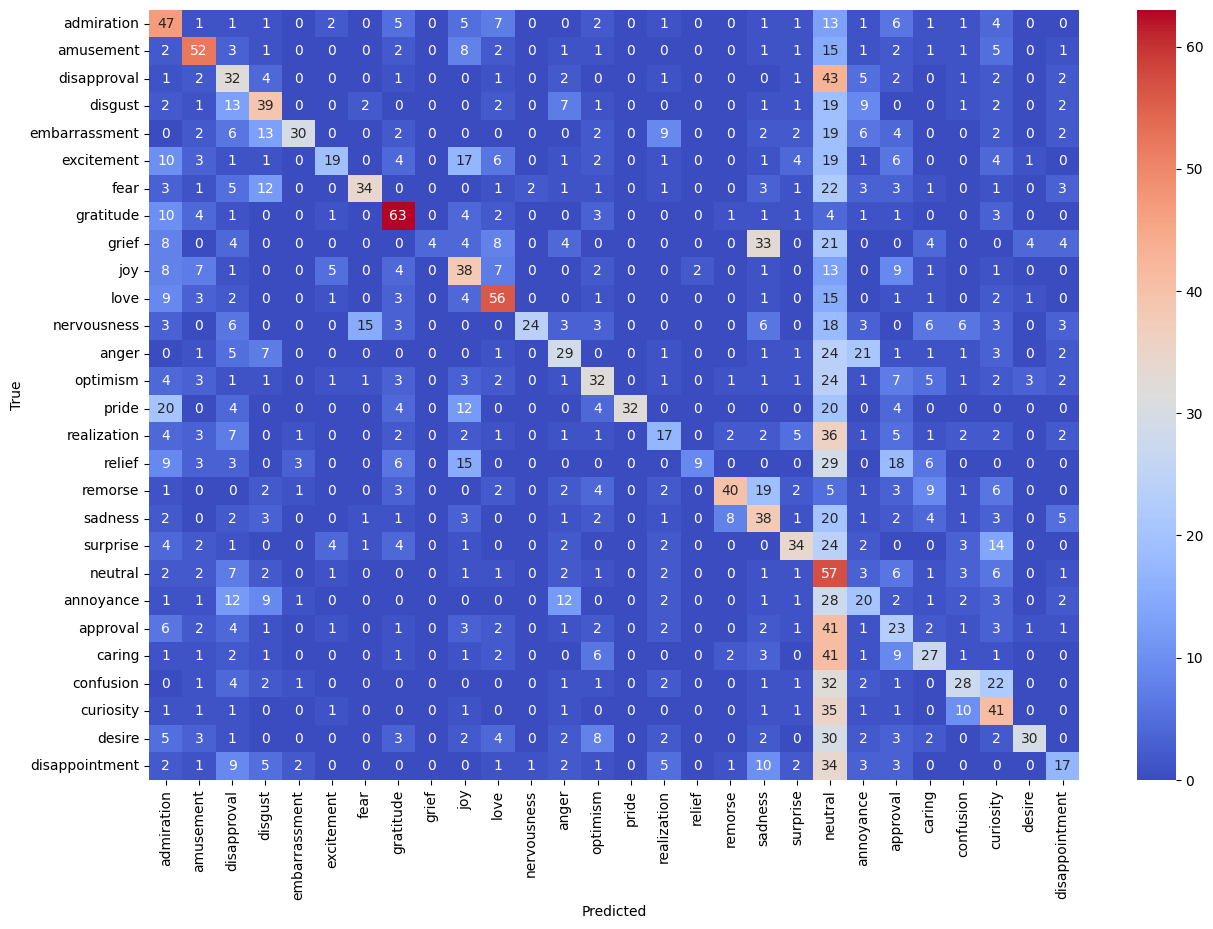

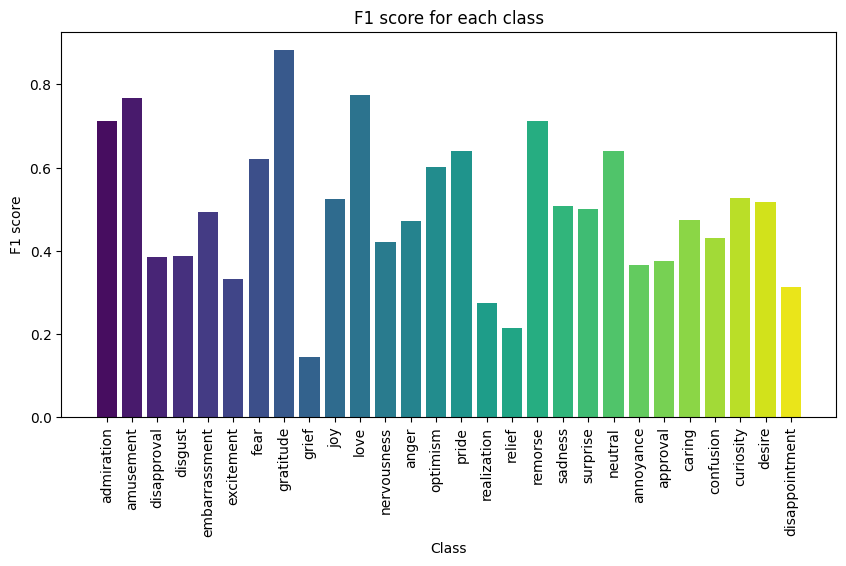

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.67                0.75                0.71                0.55                 488
amusement                           0.71                0.84                0.77                0.62                 303
disapproval                         0.30                0.55                0.39                0.24                 292
disgust                             0.28                0.65                0.39                0.24                  97
embarrassment                       0.53                0.46                0.49                0.33                  35
excitement                          0.34                0.32                0.33                0.20                  96
fear                                0.72                0.54                0.62                0.45                  90
gratitude

In [8]:
model_analysis(model, val_df, LABEL_COLS)

### Socbert_uncleaned

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.24


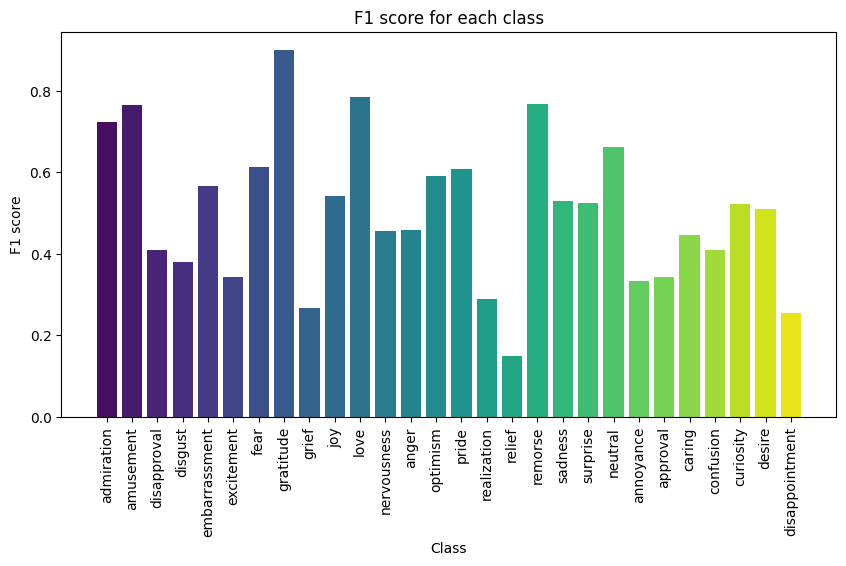

In [6]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
MODEL_NAME = 'SocbertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28,
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# creating the model with the same seed as the cleaned version
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Socbert(SCORES,
                PARAMS)  
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out_uncleaned = model_uncleaned.predict(val_df)
target_uncleaned = val_df.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {thresh_uncleaned}")
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
plot_score_barplot(target_uncleaned, best_out_uncleaned, LABEL_COLS)

Now we can compare the graphical results of the obtained models

In [4]:
_,val_df_uncleaned,_ = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
_,val_df,_ = load_dataset(DatasetEnum.GoEmotionsCleaned)

PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28, 
          'tokenizer_max_len' :100}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

MODEL_NAME = 'SocbertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_cleaned = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)
out_cleaned = model_cleaned.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
thresh_cleaned, _ = tune_sigmoid_threshold(target_cleaned, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(thresh_cleaned)
best_out_cleaned = (out_cleaned > thresh_cleaned).astype(int)

MODEL_NAME = 'SocbertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_uncleaned = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)

out_uncleaned = model_uncleaned.predict(val_df_uncleaned)
target_uncleaned = val_df_uncleaned.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(thresh_uncleaned)
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)



c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.2


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.24


C:\Users\gdema\AppData\Local\Temp\ipykernel_15448\2273644897.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


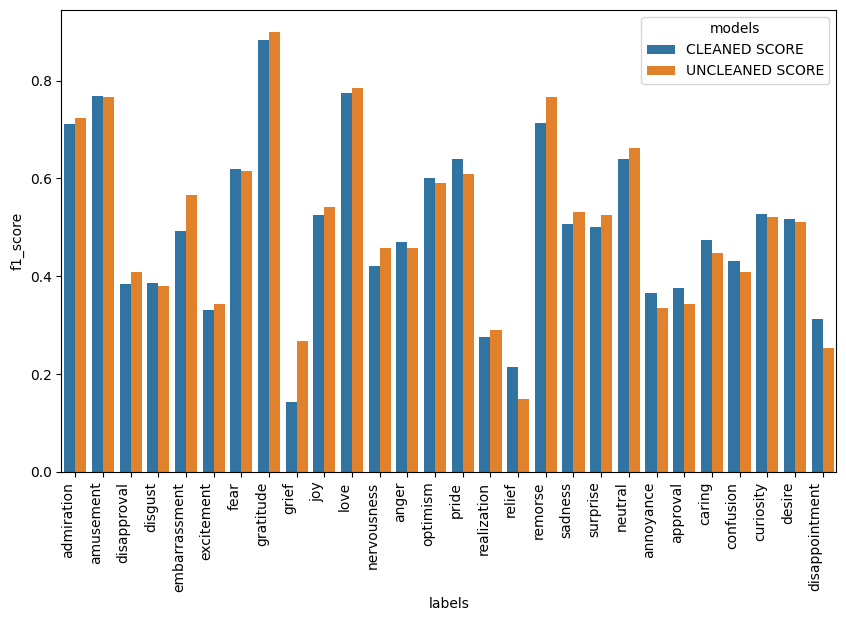

cleaned mean = 0.5001805990007133
uncleaned mean = 0.505466686547474


In [5]:
cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")



As we can see, the best model is the one trained with the standard training-set, the **uncleaned** one.

## 3. Training the final model: *Socbert*
Now we train the final model with random seed and the standard training-set version. Since we are using this training set version, setting a *max-lenght* over the which, the tokenizer will truncate the phrases makes the training a lot faster and less expensive memory-wise.<br>
The choice of **100** as the max_len value is made by analyzing the token count distribution over the dataset on the notebook **GoEmotions_data_exploration**

In [5]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

MODEL_NAME = 'Socbert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28,
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model = Socbert(SCORES,
                PARAMS) 

model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold}")

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.29


## 4. Mapping *Socbert* predictions to the Ekman taxonomy

In [ ]:
#now we predìct to the test values and map the results
#first we map the test set
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
EKMAN_LABELS = grouped_test_df.columns[grouped_test_df.columns.str.startswith('ekman_')].tolist()
# keep only grouped records
test_df = test_df.loc[grouped_test_df.index]
target= test_df.iloc[:, 1:].values
out= model.predict(grouped_test_df)
best_out = (out> threshold).astype(int)

The following are some plots related to the model *Socbert*

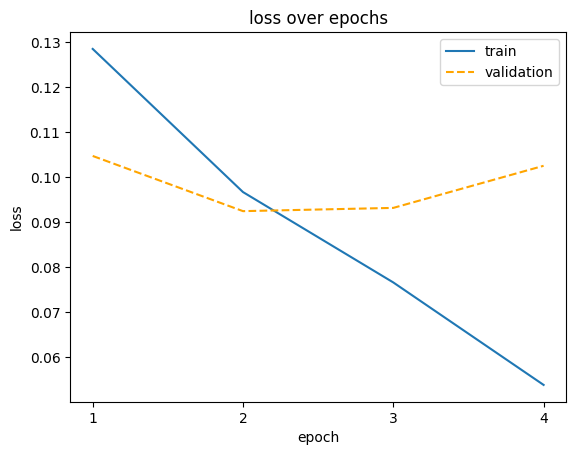

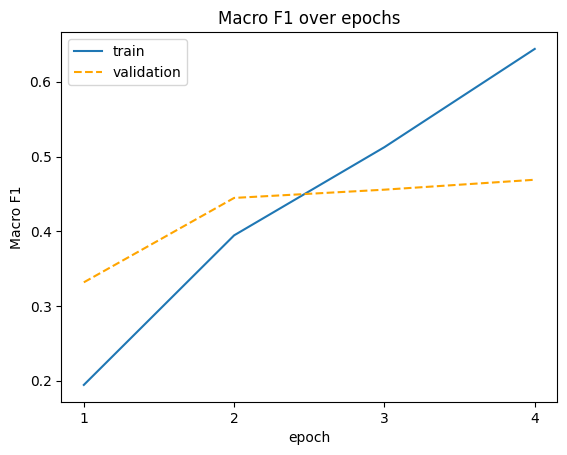

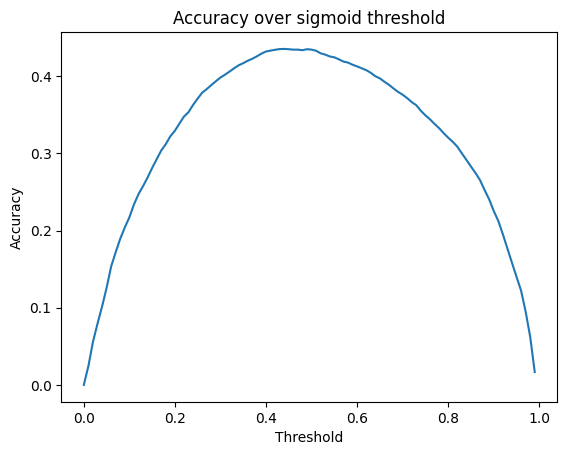

Best threshold: 0.44
Best Accuracy: 0.43531146332473275


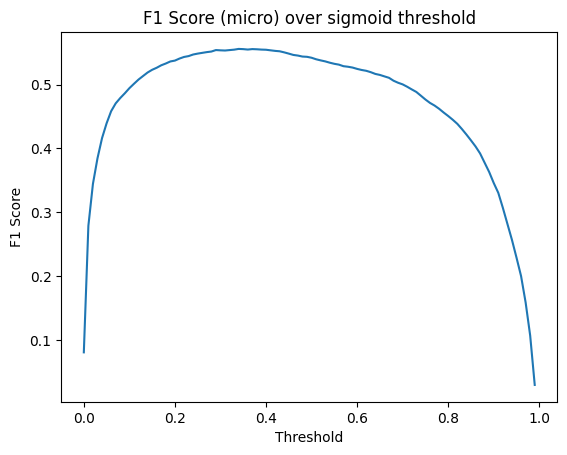

Best threshold: 0.34
Best F1 Score (micro): 0.5559400230680508


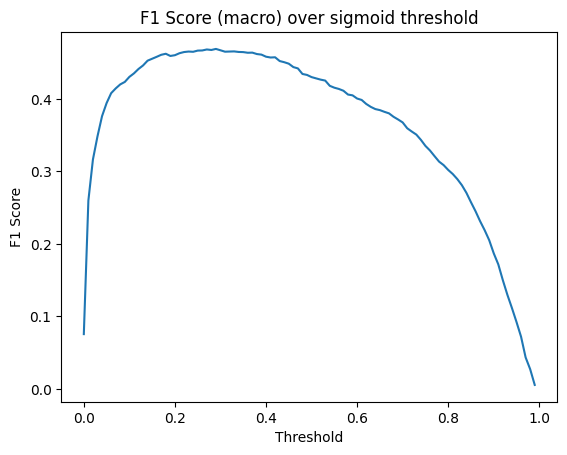

Best threshold: 0.29
Best F1 Score (macro): 0.4689044799601721


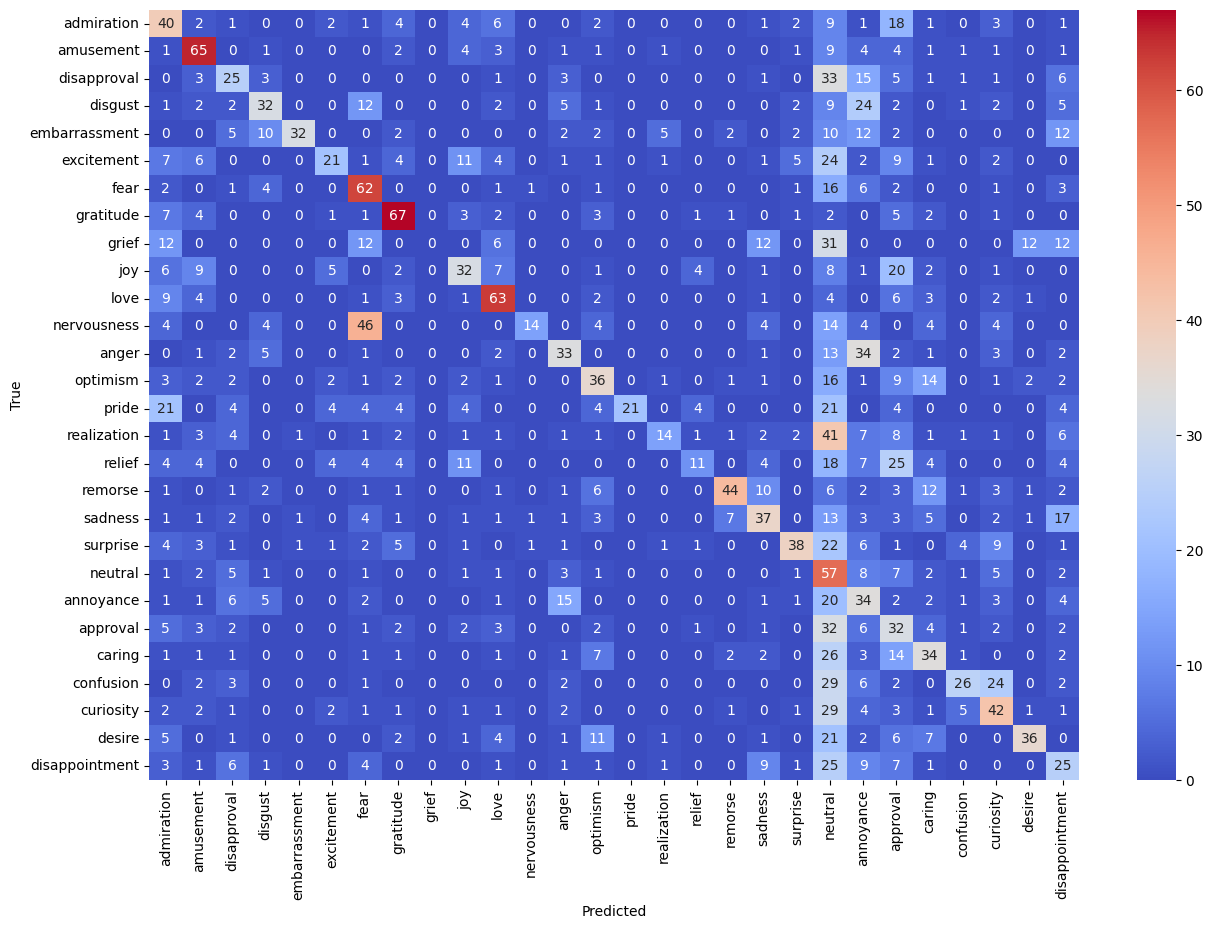

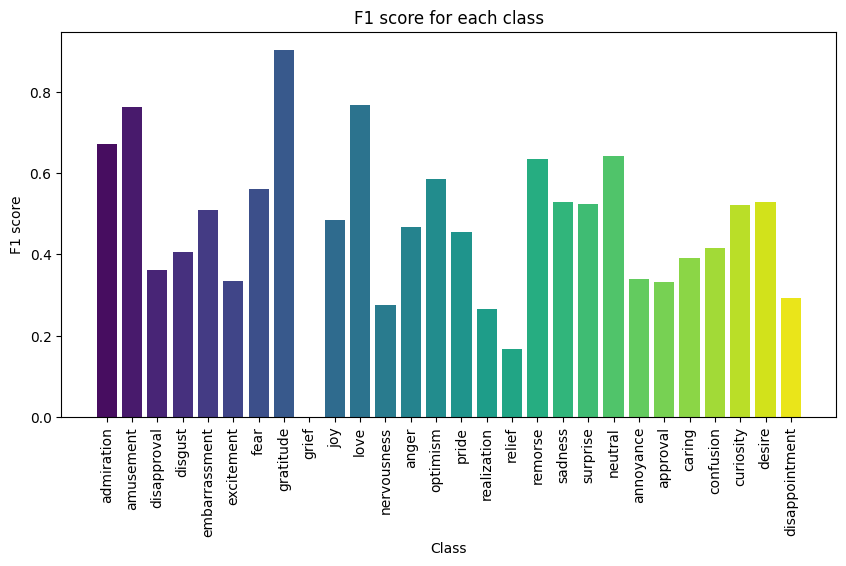

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.76                0.61                0.67                0.51                 488
amusement                           0.72                0.81                0.76                0.62                 303
disapproval                         0.38                0.35                0.36                0.22                 292
disgust                             0.39                0.42                0.41                0.25                  97
embarrassment                       0.81                0.37                0.51                0.34                  35
excitement                          0.37                0.30                0.33                0.20                  96
fear                                0.47                0.70                0.56                0.39                  90
gratitude

In [6]:
model_analysis(model, val_df, LABEL_COLS)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Threshold = 0.29


c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:55: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:55: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:55: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  value = value | dataset[column]
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\dataset_utils.py:55: FutureWarning: Operation between non bool

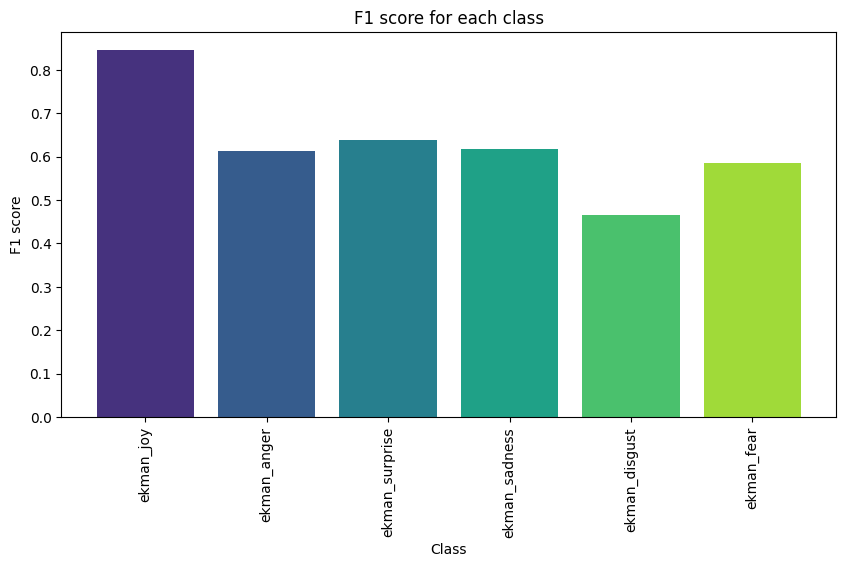

F1-score = 0.6272844890210431


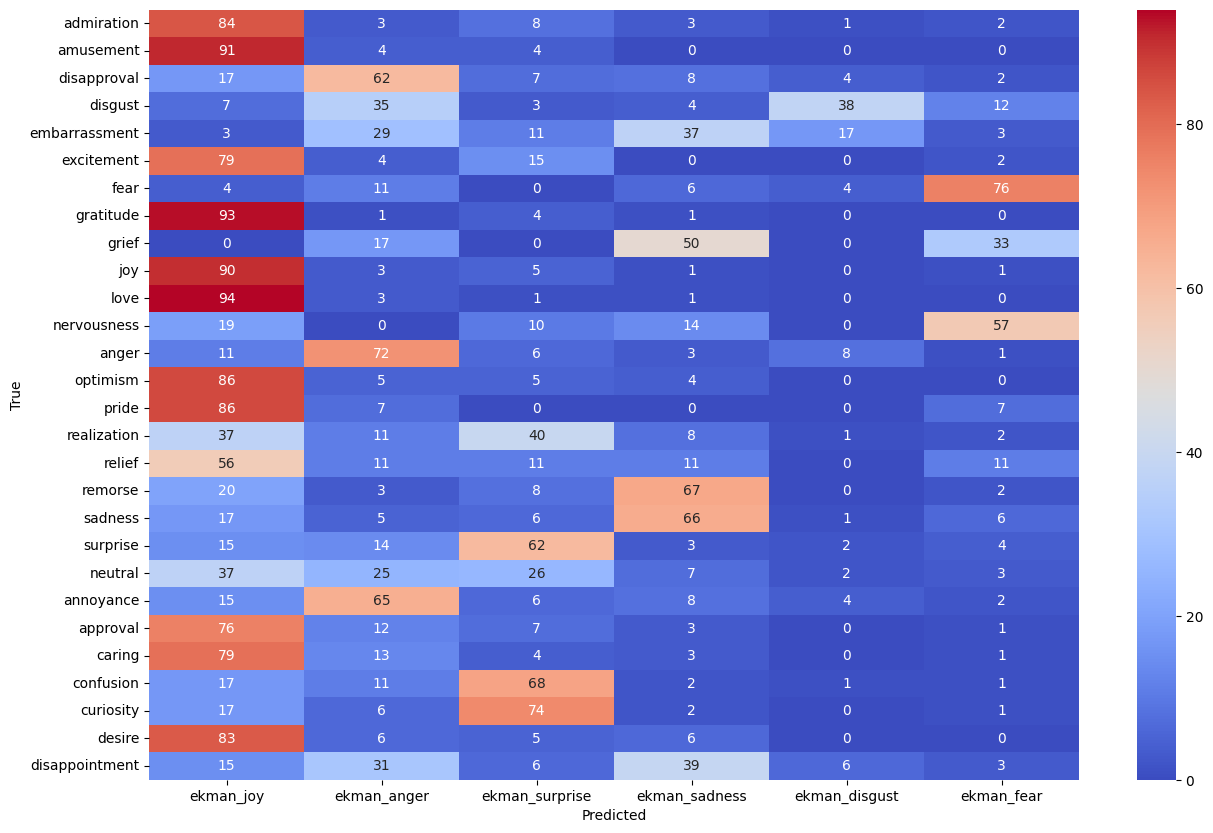

In [8]:
best_out=goemotions_apply_emotion_mapping(best_out,isDataframe=False)
score_postMap = f1_score(grouped_test_df[EKMAN_LABELS].values, best_out,average=None)
plot_score_barplot(grouped_test_df[EKMAN_LABELS].values, best_out,EKMAN_LABELS)
print (f"F1-score = {np.mean(score_postMap)}")
plot_multilabel_confusion_heatmap(test_df[LABEL_COLS].values, best_out, LABEL_COLS, EKMAN_LABELS, normalize=True, transpose=False, highlight_borders_map=GOEMOTIONS_EKMAN_MAPPING, highlight_map_true_to_pred=False)

## 5. Training with the Ekman-mapped training-set the model *Socbert_Ekman*
The dataset entry labelled with neutral emotion are dropped from the dataset: there is no neutral emotion in the Ekman taxonomy.

In [5]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

train_df=goemotions_apply_emotion_mapping(train_df)
val_df=goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)
EKMAN_LABELS = test_df.columns[test_df.columns.str.startswith('ekman_')].tolist()

MODEL_NAME = 'Socbert_Ekman'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':(len(train_df.columns) -1),
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model_preMap = Socbert(SCORES,
                PARAMS) 

model_preMap.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

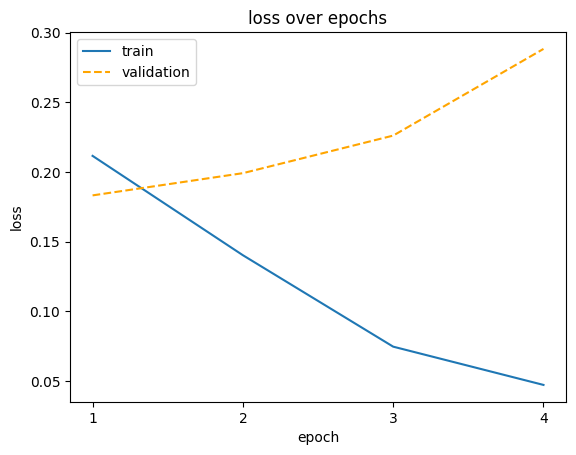

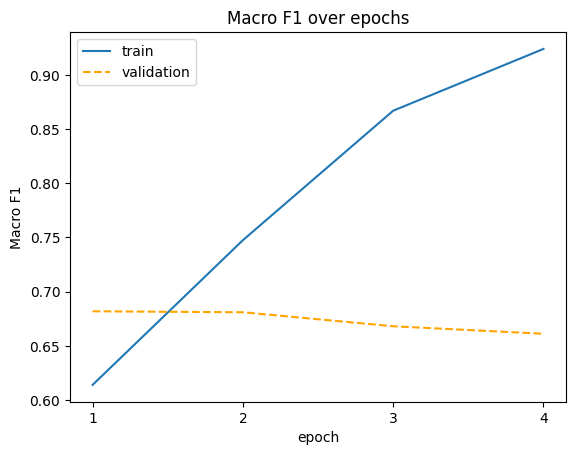

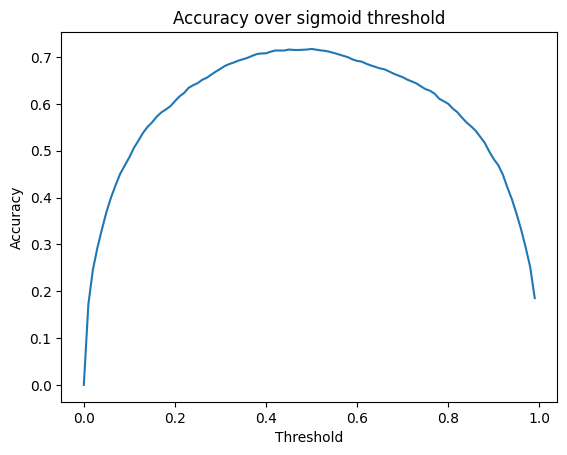

Best threshold: 0.5
Best Accuracy: 0.7175273865414711


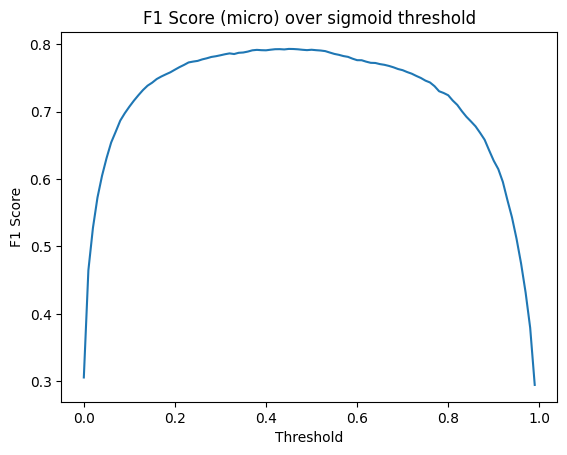

Best threshold: 0.45
Best F1 Score (micro): 0.7929330368173956


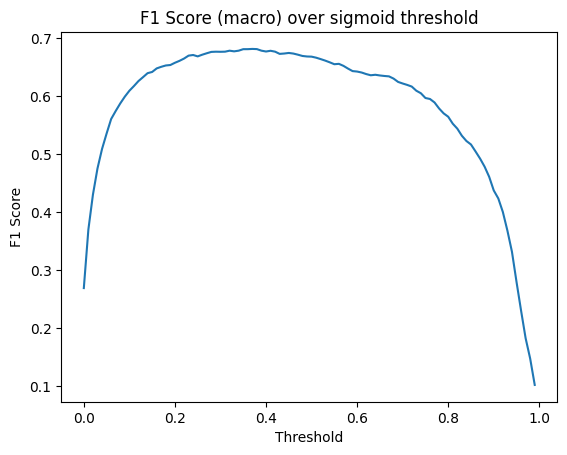

Best threshold: 0.37
Best F1 Score (macro): 0.6818777840219955


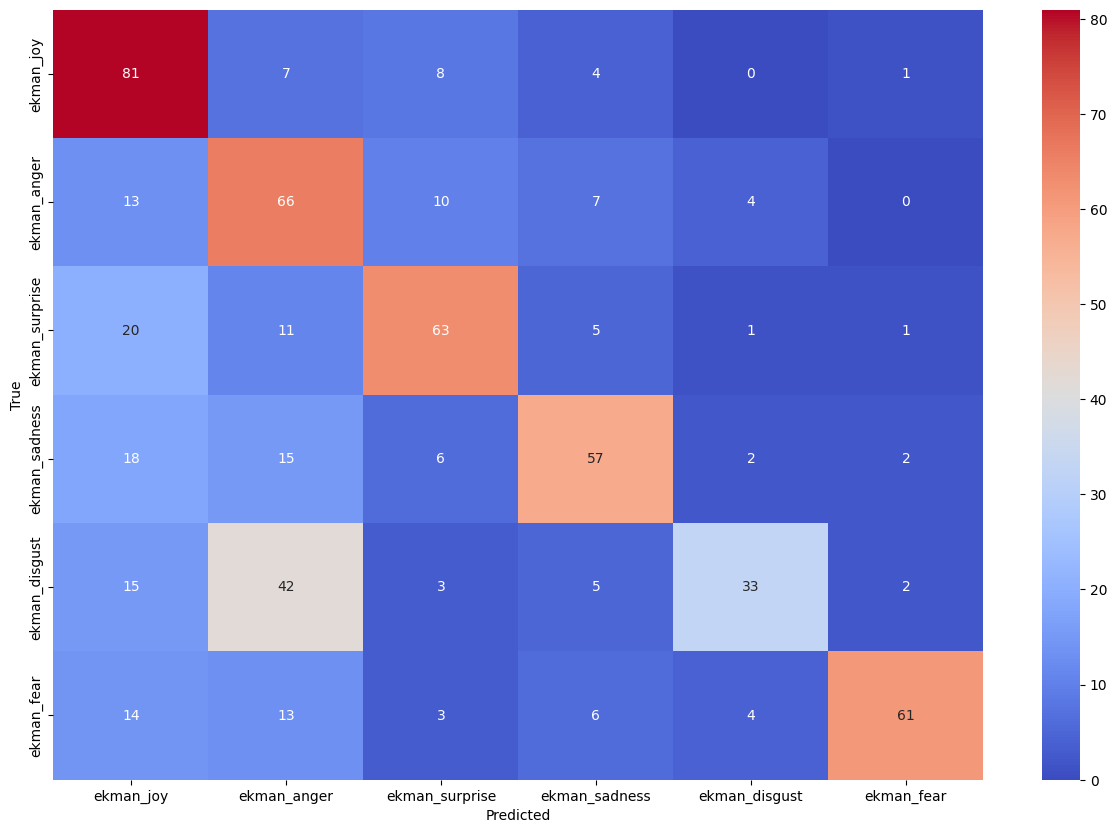

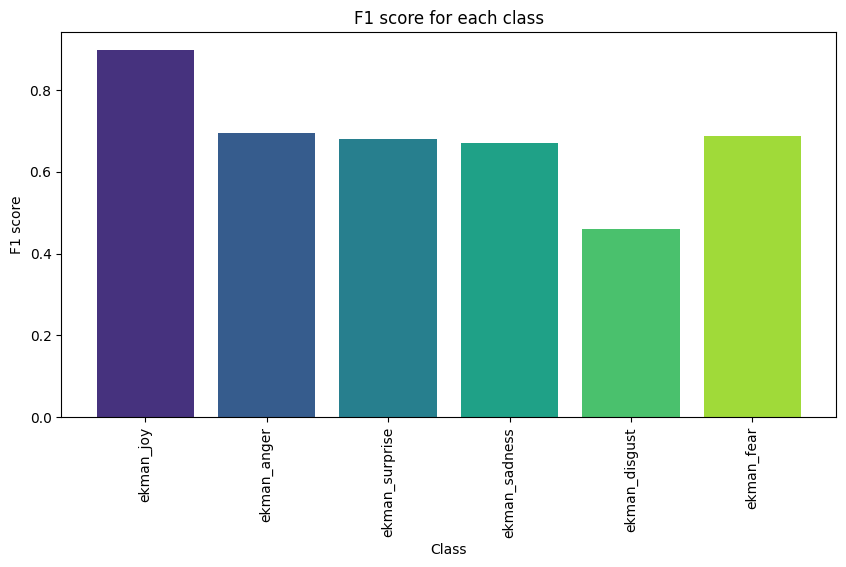

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.91                0.89                0.90                0.81                2219
ekman_anger                         0.65                0.75                0.70                0.53                 717
ekman_surprise                      0.65                0.71                0.68                0.52                 624
ekman_sadness                       0.67                0.67                0.67                0.50                 390
ekman_disgust                       0.51                0.42                0.46                0.30                  97
ekman_fear                          0.74                0.64                0.69                0.52                 105
Macro avg                           0.69                0.68                0.68                0.53                4152
Micro avg

In [9]:
model_analysis(model_preMap, val_df, EKMAN_LABELS)

### Conclusions
Mapping *Socbert* predicted results leads to a macro f1-score of **0.628** while, as we expected, the model *Socbert_Ekman* scores **0.68** on the same metric.

## 6. Testing *Socbert* generalizzation capabilities on the twitter dataset
We used the model *Socbert* to make predictions on twitter test-set. Using the predictions labelled with goemotions labels, we can analyze the generalization capabilities of the model, by comparing the predicted emotions to the actual ones, labelled following the parrot taxonomy (twitter).

In [7]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28,
          'tokenizer_max_len' :100
          
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + "Socbert" + '.pth'
model = Socbert(SCORES, PARAMS, CHECKPOINT_MODEL_FILE)
#first we calculate the threshold (we already did it but because of memory limitation we need to recalculate it)
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the following confusion matrix, for each column (which is related to a twitter emotion), the GoEmotions label mapped into the column emotion are highlighted. The mapping used as the "golden" mapping is arbitrarily chosen by the group members.

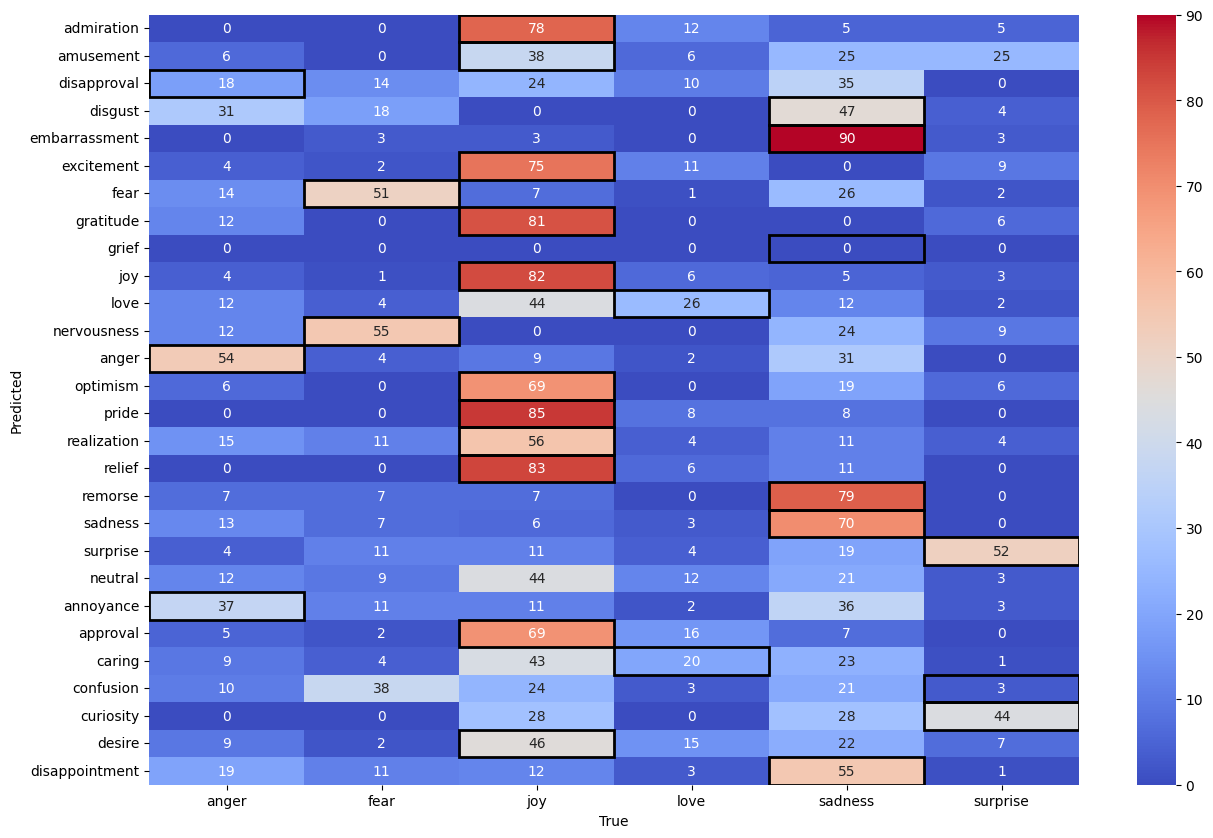

In [8]:
# get model predictions on test set of Twitter dataset
DATASET = DatasetEnum.TwitterData
train_df, val_df, test_df = load_dataset(DATASET,k_hot_encode=True)
TWITTER_LABEL = train_df.columns[1:].tolist()
out = model.predict(test_df)
best_out = (out > threshold).astype(int)
# visualize confusion matrix to understand induced mapping
HIGHLIGHT_MAP = {k.replace('twitter_', ''): v for k, v in GOEMOTIONS_TWITTER_MAPPING.items()}
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABEL].values, best_out, TWITTER_LABEL, LABEL_COLS, normalize=True, transpose=True, highlight_borders_map=HIGHLIGHT_MAP)